In [3]:
import os
import sys
import imageio
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns
import mplotutils as mpu
import cartopy.crs as ccrs
from netCDF4 import Dataset
import metpy.calc as mpcalc
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage
import cartopy.feature as cfeature
from wrf import to_np, getvar, latlon_coords, interplevel,geo_bounds, CoordPair
from matplotlib.colors import from_levels_and_colors, ListedColormap, DivergingNorm, LinearSegmentedColormap

%matplotlib inline

# Horizontal Maps for Analysis of Initiation Environment

In [4]:
def horizontal_map(variable_name, date, start_hour, 
                                  end_hour, pressure_level=False, 
                                  subset=False, initiation=False, 
                                  save=False, gif=False):
    
    '''This function plots the chosen variable for the analysis 
    of the environment on a horizontal (2D) map. Supported variables for plotting procedure 
    are updraft, reflectivity, helicity, pw, cape, cin, ctt, temperature_surface, wind_shear, rh, 
    omega, pvo, avo, theta_e, water_vapor, uv_wind, 
    updraft_reflectivity and divergence.'''
    
    ### Preprocessing of data and amalgamation ###
    
    # Get the list of all needed wrf files
    data_directory = '/scratch3/thomasl/work/data/casestudy_baden/'
    
    # Define save directory
    save_dir = '/scratch3/thomasl/work/retrospective_part'\
                '/casestudy_baden/horizontal_maps/'

    # Change extent of plot
    subset_extent = [6.2, 9.4, 46.5, 48.5]
    
    # Set the location of the initiation of the thunderstorm
    initiation_location = CoordPair(lat=47.25, lon=7.85)

    # Predefine some variables
    # 2D variables:
    if variable_name == 'updraft':
        variable_name = 'W_UP_MAX'
        title_name = 'Maximum Z-Wind Updraft'
        colorbar_label = 'Max Z-Wind Updraft [$m$ $s^-$$^1$]'
        save_name = 'updraft'
        variable_min = 0
        variable_max = 30 # original value = 34.5
        
        # Check if a certain pressure_level was defined.
        if pressure_level != False: 
            sys.exit('The variable {} is a 2D variable. ' \
                     'Definition of a pressure_level for ' \
                     'plotting process is not required.'.format(variable_name))
        
    elif variable_name == 'reflectivity':
        variable_name = 'REFD_MAX'
        title_name = 'Maximum Derived Radar Reflectivity'
        colorbar_label = 'Maximum Derived Radar Reflectivity [$dBZ$]'
        save_name = 'reflectivity'
        variable_min = 0
        variable_max = 75 # original value = 57.6
        
        # Check if a certain pressure_level was defined.
        if pressure_level != False: 
            sys.exit('The variable {} is a 2D variable. ' \
                     'Definition of a pressure_level for ' \
                     'plotting process is not required.'.format(variable_name))
        
    elif variable_name == 'helicity':
        variable_name = 'UP_HELI_MAX'
        title_name = 'Maximum Updraft Helicity'
        colorbar_label = 'Maximum Updraft Helicity [$m^{2}$ $s^{-2}$]'
        save_name = 'helicity'
        variable_min = 0 
        variable_max = 140 # original value = 272.8
        
        # Check if a certain pressure_level was defined.
        if pressure_level != False: 
            sys.exit('The variable {} is a 2D variable. ' \
                     'Definition of a pressure_level for ' \
                     'plotting process is not required.'.format(variable_name))
        
    elif variable_name == 'pw':
        title_name = 'Precipitable Water'
        colorbar_label = 'Precipitable Water [$kg$ $m^{-2}$]'
        save_name = 'pw'
        variable_min = 0 # original value = 2.8
        variable_max = 50 # original value = 46.4
        
        # Check if a certain pressure_level was defined.
        if pressure_level != False: 
            sys.exit('The variable {} is a 2D variable. ' \
                     'Definition of a pressure_level for ' \
                     'plotting process is not required.'.format(variable_name))
    
    elif variable_name == 'cape':
        variable_name = 'cape_2d'
        title_name = 'CAPE'
        colorbar_label = 'Convective Available Potential Energy' \
                            '[$J$ $kg^{-1}$]'
        save_name = 'cape'
        variable_min = 0 # original value: 0.1
        variable_max = 3000 # original value: 2698.2
        
        # Check if a certain pressure_level was defined.
        if pressure_level != False: 
            sys.exit('The variable {} is a 2D variable. ' \
                     'Definition of a pressure_level for ' \
                     'plotting process is not required.'.format(variable_name))
        
    elif variable_name == 'cin':
        variable_name = 'cape_2d'
        title_name = 'CIN'
        colorbar_label = 'Convective Inhibition [$J$ $kg^{-1}$]'
        save_name = 'cin'
        variable_min = 0 # original value = 0.1
        variable_max = 100 #original value = 431.2

        # Check if a certain pressure_level was defined.
        if pressure_level != False: 
            sys.exit('The variable {} is a 2D variable. ' \
                     'Definition of a pressure_level for ' \
                     'plotting process is not required.'.format(variable_name))
        
    elif variable_name == 'ctt':
        title_name = 'Cloud Top Temperature'
        colorbar_label = 'Cloud Top Temperature [$K$]'
        save_name = 'cct'
        variable_min = 210 # original value = 209.3
        variable_max = 300 # original value = 302.4
        
        # Check if a certain pressure_level was defined.
        if pressure_level != False: 
            sys.exit('The variable {} is a 2D variable. ' \
                     'Definition of a pressure_level for ' \
                     'plotting process is not required.'.format(variable_name))
    
    elif variable_name == 'temperature_surface':
        variable_name = 'T2'
        title_name = 'Temperature @ 2 m'
        colorbar_label = 'Temperature [$K$]'
        save_name = 'temperature_surface'
        variable_min = 285
        variable_max = 305

        # Check if a certain pressure_level was defined.
        if pressure_level != False: 
            sys.exit('The variable {} is a 2D variable. ' \
                     'Definition of a pressure_level for ' \
                     'plotting process is not required.'.format(variable_name))
            
    elif variable_name == 'wind_shear':
        variable_name = 'slp'
        title_name = 'SLP, Wind @ 850hPa, Wind @ 500hPa\n' \
                        'and 500-850hPa Vertical Wind Shear'
        save_name = 'wind_shear'
        variable_min = 1000
        variable_max = 1020

        # Check if a certain pressure_level was defined.
        if pressure_level != False: 
            sys.exit('The variable {} is a 2D variable. ' \
                     'Definition of a pressure_level for ' \
                     'plotting process is not required.'.format(variable_name))
            
    # 3D variables:
    elif variable_name == 'rh':
        title_name = 'Relative Humidity'
        colorbar_label = 'Relative Humidity [$pct$]'
        save_name = 'rh'
        variable_min = 0
        variable_max = 100
        
        # Check if a certain pressure_level was defined.
        if pressure_level == False: 
            sys.exit('The variable {} is a 3D variable. ' \
                     'Definition of a pressure_level for ' \
                     'plotting process is required.'.format(variable_name))
        
    elif variable_name == 'omega':
        title_name = 'Vertical Motion'
        colorbar_label = 'Omega [$Pa$ $s^-$$^1$]'
        save_name = 'omega'
        variable_min = -50 # original value = -179.2
        variable_max = 50 # original value = 64.9
        
        # Check if a certain pressure_level was defined.
        if pressure_level == False: 
            sys.exit('The variable {} is a 3D variable. ' \
                     'Definition of a pressure_level for ' \
                     'plotting process is required.'.format(variable_name))
            
    elif variable_name == 'pvo':
        title_name = 'Potential Vorticity'
        colorbar_label = 'Potential Vorticity [$PVU$]'
        save_name = 'pvo'
        variable_min = -1 # original value = 1857.8
        variable_max = 9 # original value = 2391.8
        
        # Check if a certain pressure_level was defined.
        if pressure_level == False: 
            sys.exit('The variable {} is a 3D variable. ' \
                     'Definition of a pressure_level for ' \
                     'plotting process is required.'.format(variable_name))
            
    elif variable_name == 'avo':
        title_name = 'Absolute Vorticity'
        colorbar_label = 'Absolute Vorticity [$10^{-5}$' \
                            '$s^{-1}$]'
        save_name = 'avo'
        variable_min = -250 #-600
        variable_max = 250 #750
        
        # Check if a certain pressure_level was defined.
        if pressure_level == False: 
            sys.exit('The variable {} is a 3D variable. ' \
                     'Definition of a pressure_level for ' \
                     'plotting process is required.'.format(variable_name))
    
    elif variable_name == 'theta_e':
        title_name = 'Theta-E'
        colorbar_label = 'Theta-E [$K$]'
        save_name = 'theta_e'
        variable_min = 310 # original value = -14.7
        variable_max = 340 # original value = 553.4
        
        # Check if a certain pressure_level was defined.
        if pressure_level == False: 
            sys.exit('The variable {} is a 3D variable. ' \
                     'Definition of a pressure_level for ' \
                     'plotting process is required.'.format(variable_name))
            
    elif variable_name == 'water_vapor':
        variable_name = 'QVAPOR'
        title_name = 'Water Vapor Mixing Ratio'
        colorbar_label = 'Water Vapor Mixing Ratio [$g$ $kg^{-1}$]'
        save_name = 'water_vapor'
        variable_min = 5
        variable_max = 15
        
        # Check if a certain pressure_level was defined.
        if pressure_level == False: 
            sys.exit('The variable {} is a 3D variable. ' \
                     'Definition of a pressure_level for ' \
                     'plotting process is required.'.format(variable_name))
    
    elif variable_name == 'uv_wind':
        variable_name = 'wspd_wdir'
        title_name = 'Wind Speed and Direction'
        colorbar_label = 'Wind Speed [$m$ $s^{-1}$]'
        save_name = 'uv_wind'
        variable_min = 0
        variable_max = 10 # original value = 360

        # Check if a certain pressure_level was defined.
        if pressure_level == False: 
            sys.exit('The variable {} is a 3D variable. ' \
                     'Definition of a pressure_level for ' \
                     'plotting process is required.'.format(variable_name))
            
    elif variable_name == 'updraft_reflectivity':
        variable_name = 'W_UP_MAX'
        title_name = 'Updraft and Reflectivity'
        colorbar_label = 'Max Z-Wind Updraft [$m$ $s^-$$^1$]'
        save_name = 'updraft_reflectivity'
        variable_min = 0
        variable_max = 35 # original value = 34.5
        
        # Check if a certain pressure_level was defined.
        if pressure_level == False: 
            sys.exit('The variable {} is a 3D variable. ' \
                     'Definition of a pressure_level for ' \
                     'plotting process is required.'.format(variable_name))
        
    elif variable_name == 'divergence':
        variable_name = 'ua'
        title_name = 'Horizontal Wind Divergence'
        colorbar_label = 'Divergence [$10^{-6}$ $s^{-1}$]'
        save_name = 'divergence'
        variable_min = -2.5
        variable_max = 2.5
            
        # Check if a certain pressure_level was defined.
        if pressure_level == False: 
            sys.exit('The variable {} is a 3D variable. ' \
                     'Definition of a pressure_level for ' \
                     'plotting process is required.'.format(variable_name))
            
    wrflist = list()
    for (dirpath, dirnames, filenames) in os.walk(data_directory):
        wrflist += [os.path.join(dirpath, file) for file in filenames]
    
    ### Plotting Iteration ###
    
    # Iterate over a list of hourly timesteps
    time = list()
    for i in range(start_hour, end_hour):
        time = str(i).zfill(2)

        # Iterate over all 5 minutes steps of hour
        for j in range(0, 60, 5):
            minutes = str(j).zfill(2)
                
            # Load the netCDF files out of the wrflist
            ncfile = [Dataset(x) for x in wrflist
                if x.endswith('{}_{}:{}:00'.format(date, time, minutes))]
            
            # Load variable(s)
            if title_name == 'CAPE':
                variable = getvar(ncfile, variable_name)[0,:]
                
            elif title_name == 'CIN':
                variable = getvar(ncfile, variable_name)[1,:]
                
            elif variable_name == 'ctt':
                variable = getvar(ncfile, variable_name, units='K')
                
            elif variable_name == 'wspd_wdir':
                variable = getvar(ncfile, variable_name)[0,:]
            
            elif variable_name == 'QVAPOR':
                variable = getvar(ncfile, variable_name)*1000 # convert to g/kg
                    
            else:
                variable = getvar(ncfile, variable_name)

            if variable_name == 'slp':
                slp = variable.squeeze()
                
                ua = getvar(ncfile, 'ua')
                va = getvar(ncfile, 'va')

                p = getvar(ncfile, 'pressure')

                u_wind850 = interplevel(ua, p, 850)
                v_wind850 = interplevel(va, p, 850)

                u_wind850 = u_wind850.squeeze()
                v_wind850 = v_wind850.squeeze()

                u_wind500 = interplevel(ua, p, 500)
                v_wind500 = interplevel(va, p, 500)

                u_wind500 = u_wind500.squeeze()
                v_wind500 = v_wind500.squeeze()

                slp = ndimage.gaussian_filter(slp, sigma=3, order=0)
            
            # Interpolating 3d data to a horizontal pressure level
            if pressure_level != False:
                p = getvar(ncfile, 'pressure')
                variable_pressure = interplevel(variable, p, 
                                                pressure_level)
                variable = variable_pressure
                
            if variable_name == 'wspd_wdir':
                ua = getvar(ncfile, 'ua')
                va = getvar(ncfile, 'va')
                u_pressure = interplevel(ua, p, pressure_level)
                v_pressure = interplevel(va, p, pressure_level)
                
            elif title_name == 'Updraft and Reflectivity':
                reflectivity = getvar(ncfile, 'REFD_MAX')
                
            elif title_name == 'Difference in Theta-E values':
                variable = getvar(ncfile, variable_name)
                
                p = getvar(ncfile, 'pressure')
                variable_pressure1 = interplevel(variable, p, '950')
                variable_pressure2 = interplevel(variable, p, '950')
                
            elif variable_name == 'ua':
                va = getvar(ncfile, 'va')

                p = getvar(ncfile, 'pressure')

                v_pressure = interplevel(va, p, pressure_level)

                u_wind = variable.squeeze()
                v_wind = v_pressure.squeeze()

                u_wind.attrs['units']='meters/second'
                v_wind.attrs['units']='meters/second'
                
                lats, lons = latlon_coords(variable)
                lats = lats.squeeze()
                lons = lons.squeeze()

                dx, dy = mpcalc.lat_lon_grid_deltas(to_np(lons), to_np(lats))

                divergence = mpcalc.divergence(u_wind, v_wind, dx, dy, dim_order='yx')
                divergence = divergence*1e3


            # Define cart projection
            lats, lons = latlon_coords(variable)
            cart_proj = ccrs.LambertConformal(central_longitude=8.722206, 
                                    central_latitude=46.73585)

            bounds = geo_bounds(wrfin=ncfile)

            # Create figure
            if variable_name == 'slp':
                fig = plt.figure(figsize=(15, 10), facecolor='black')
                
            else:
                fig = plt.figure(figsize=(15,10))
            
            ax = plt.axes(projection=cart_proj)

            ### Set map extent ###
            domain_extent = [3.701088, 13.814863, 43.85472,49.49499]

            if subset == True:
                ax.set_extent([subset_extent[0],subset_extent[1],
                               subset_extent[2],subset_extent[3]],
                                 ccrs.PlateCarree())
                
            else: 
                ax.set_extent([domain_extent[0]+0.7,domain_extent[1]-0.7,
                               domain_extent[2]+0.1,domain_extent[3]-0.1],
                                 ccrs.PlateCarree())

            # Plot contour of variables
            levels_num = 11
            levels = np.linspace(variable_min, variable_max, levels_num)
            
            # Creating new colormap for diverging colormaps
            def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
                    new_cmap = LinearSegmentedColormap.from_list(
                        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, 
                                                            b=maxval),
                        cmap(np.linspace(minval, maxval, n)))
                    return new_cmap
            
            cmap = plt.get_cmap('RdYlBu')
            
            if title_name == 'CIN':
                cmap = ListedColormap(sns.cubehelix_palette(levels_num-1, 
                                        start=.5, rot=-.75, reverse=True))
                variable_plot = plt.contourf(to_np(lons), to_np(lats), to_np(variable), 
                                 levels=levels, transform=ccrs.PlateCarree(), extend='max', 
                                 cmap=cmap)
                initiation_color = 'r*'
                
            elif variable_name == 'ctt':
                cmap = ListedColormap(sns.cubehelix_palette(levels_num-1, 
                                        start=.5, rot=-.75, reverse=True))
                variable_plot = plt.contourf(to_np(lons), to_np(lats), to_np(variable), 
                                 levels=levels, transform=ccrs.PlateCarree(), extend='both', 
                                 cmap=cmap)
                initiation_color = 'r*'
                
            elif variable_name == 'pvo':
                cmap = plt.get_cmap('RdYlBu_r')
                new_cmap = truncate_colormap(cmap, 0.05, 0.9)
                new_norm = DivergingNorm(vmin=-1., vcenter=2., vmax=10)
                
                variable_plot = plt.contourf(to_np(lons), to_np(lats), to_np(variable), 
                                 levels=levels, transform=ccrs.PlateCarree(), 
                                 cmap=new_cmap, extend='both', norm=new_norm)
                initiation_color = 'k*'
                
            elif variable_name == 'avo':
                cmap = plt.get_cmap('RdYlBu_r')
                new_cmap = truncate_colormap(cmap, 0.05, 0.9)
                new_norm = DivergingNorm(vmin=variable_min, vcenter=0, vmax=variable_max)
                
                variable_plot = plt.contourf(to_np(lons), to_np(lats), to_np(variable), 
                                 levels=levels, transform=ccrs.PlateCarree(), 
                                 cmap=new_cmap, extend='both', norm=new_norm)
                initiation_color = 'k*'
                
            elif variable_name == 'omega':
                new_cmap = truncate_colormap(cmap, 0.05, 0.9)
                new_norm = DivergingNorm(vmin=variable_min, vcenter=0, vmax=variable_max)

                variable_plot = plt.contourf(to_np(lons), to_np(lats), to_np(variable), 
                                 levels=levels, transform=ccrs.PlateCarree(), 
                                 cmap=new_cmap, extend='both', norm=new_norm)
                initiation_color = 'k*'
                
            elif variable_name == 'ua':
                new_cmap = truncate_colormap(cmap, 0.05, 0.9)
                new_norm = DivergingNorm(vmin=variable_min, vcenter=0, vmax=variable_max)

                variable_plot = plt.contourf(to_np(lons), to_np(lats), divergence, 
                                 levels=levels, transform=ccrs.PlateCarree(), 
                                 cmap=new_cmap, extend='both', norm=new_norm)
                initiation_color = 'k*'
                
            elif variable_name == 'UP_HELI_MAX' or variable_name == 'W_UP_MAX' or variable_name == 'QVAPOR':
                cmap = ListedColormap(sns.cubehelix_palette(levels_num-1, 
                                        start=.5, rot=-.75))
                variable_plot = plt.contourf(to_np(lons), to_np(lats), 
                                to_np(variable), levels=levels, extend='max',
                                transform=ccrs.PlateCarree(),cmap=cmap)
                initiation_color = 'r*'
                
            elif variable_name == 'theta_e' or variable_name == 't2':
                cmap = ListedColormap(sns.cubehelix_palette(levels_num-1, 
                                        start=.5, rot=-.75))
                variable_plot = plt.contourf(to_np(lons), to_np(lats), 
                                to_np(variable), levels=levels, extend='both',
                                transform=ccrs.PlateCarree(),cmap=cmap)
                initiation_color = 'r*'

                
            elif variable_name == 'REFD_MAX':
                levels = np.arange(5., 75., 5.)
                dbz_rgb = np.array([[4,233,231],
                                    [1,159,244], [3,0,244],
                                    [2,253,2], [1,197,1],
                                    [0,142,0], [253,248,2],
                                    [229,188,0], [253,149,0],
                                    [253,0,0], [212,0,0],
                                    [188,0,0],[248,0,253],
                                    [152,84,198]], np.float32) / 255.0
                dbz_cmap, dbz_norm = from_levels_and_colors(levels, dbz_rgb,
                                                           extend='max')
                
                variable_plot = plt.contourf(to_np(lons), to_np(lats), 
                                 to_np(variable), levels=levels, extend='max',
                                 transform=ccrs.PlateCarree(), cmap=dbz_cmap,
                                            norm=dbz_norm)
                initiation_color = 'r*'
                
            elif variable_name == 'slp':
                ax.background_patch.set_fill(False)
                    
                wslice = slice(1, None, 12)
                # Plot 850-hPa wind vectors
                vectors850 = ax.quiver(to_np(lons)[wslice, wslice], to_np(lats)[wslice, wslice],
                                       to_np(u_wind850)[wslice, wslice], to_np(v_wind850)[wslice, wslice],
                                       headlength=4, headwidth=3, scale=400, color='gold', label='850mb wind', 
                                       transform=ccrs.PlateCarree(), zorder=2)

                # Plot 500-hPa wind vectors
                vectors500 = ax.quiver(to_np(lons)[wslice, wslice], to_np(lats)[wslice, wslice],
                                       to_np(u_wind500)[wslice, wslice], to_np(v_wind500)[wslice, wslice],
                                       headlength=4, headwidth=3, scale=400, color='cornflowerblue', zorder=2,
                                       label='500mb wind', transform=ccrs.PlateCarree())

                # Plot 500-850 shear
                shear = ax.quiver(to_np(lons[wslice, wslice]), to_np(lats[wslice, wslice]),
                                  to_np(u_wind500[wslice, wslice]) - to_np(u_wind850[wslice, wslice]),
                                  to_np(v_wind500[wslice, wslice]) - to_np(v_wind850[wslice, wslice]),
                                  headlength=4, headwidth=3, scale=400, color='deeppink', zorder=2,
                                  label='500-850mb shear', transform=ccrs.PlateCarree())

                contour = ax.contour(to_np(lons), to_np(lats), slp, levels=levels, colors='lime', 
                                     linewidths=2, transform=ccrs.PlateCarree(), alpha=0.5, zorder=1)
                ax.clabel(contour, fontsize=12, inline=1, inline_spacing=4, fmt='%i')
                
                # Add a legend
                ax.legend(('850mb wind', '500mb wind', '500-850mb shear'), loc=4)

                # Manually set colors for legend
                legend = ax.get_legend()
                legend.legendHandles[0].set_color('gold')
                legend.legendHandles[1].set_color('cornflowerblue')
                legend.legendHandles[2].set_color('deeppink')
                
                initiation_color = 'w*'
            
            else:
                cmap = ListedColormap(sns.cubehelix_palette(10, 
                                        start=.5, rot=-.75))
                variable_plot = plt.contourf(to_np(lons), to_np(lats), 
                                to_np(variable), levels=levels,
                                transform=ccrs.PlateCarree(),cmap=cmap)
                initiation_color = 'r*'
                         
            # Plot reflectivity contours with colorbar 
            if title_name == 'Updraft and Reflectivity':
                levels = np.arange(35., 75., 5.)
                dbz_rgb = np.array([[253,248,2],
                        [229,188,0], [253,149,0],
                        [253,0,0], [212,0,0],
                        [188,0,0],[248,0,253],
                        [152,84,198]], np.float32) / 255.0
                dbz_cmap, dbz_norm = from_levels_and_colors(levels, dbz_rgb,
                                               extend='max')                

                contours = plt.contour(to_np(lons), to_np(lats), 
                                           to_np(reflectivity), 
                                           levels=levels, 
                                           transform=ccrs.PlateCarree(), 
                                           cmap=dbz_cmap, norm=dbz_norm, 
                                           linewidths=1)

                cbar_refl = mpu.colorbar(contours, ax, orientation='vertical', aspect=10, shrink=.5)
                cbar_refl.set_label('Maximum Derived Radar Reflectivity' \
                                        '[$dBZ$]', fontsize=12.5)
                colorbar_lines = cbar_refl.ax.get_children()
                colorbar_lines[0].set_linewidths([10]*5)
            
            # Add wind quivers for every 10th data point
            if variable_name == 'wspd_wdir':
                plt.quiver(to_np(lons[::10,::10]), to_np(lats[::10,::10]),
                            to_np(u_pressure[::10, ::10]), 
                            to_np(v_pressure[::10, ::10]),
                            transform=ccrs.PlateCarree())
            
            # Plot colorbar
            if variable_name == 'slp':
                pass
            else:
                cbar = mpu.colorbar(variable_plot, ax, orientation='horizontal', aspect=40, shrink=.05, pad=0.1)
                cbar.set_label(colorbar_label, fontsize=15)
                cbar.set_ticks(levels)
            
            # Add borders and coastlines
            if variable_name == 'slp':
                ax.add_feature(cfeature.BORDERS.with_scale('10m'), 
                           edgecolor='white', linewidth=2)
                ax.add_feature(cfeature.COASTLINE.with_scale('10m'), 
                           edgecolor='white', linewidth=2)
            else:
                ax.add_feature(cfeature.BORDERS.with_scale('10m'), 
                               linewidth=0.8)
                ax.add_feature(cfeature.COASTLINE.with_scale('10m'), 
                               linewidth=0.8)
            
            ### Add initiation location ###
            if initiation == True:
                ax.plot(initiation_location.lon, initiation_location.lat, 
                        initiation_color, markersize=20, transform=ccrs.PlateCarree())
            
            # Add gridlines
            lon = np.arange(0, 20, 1)
            lat = np.arange(40, 60, 1)

            gl = ax.gridlines(xlocs=lon, ylocs=lat, zorder=3)
            
            # Add tick labels
            mpu.yticklabels(lat, ax=ax, fontsize=12.5)
            mpu.xticklabels(lon, ax=ax, fontsize=12.5)
            
            # Make nicetime
            file_name = '{}wrfout_d02_{}_{}:{}:00'.format(data_directory, 
                                                          date, time, minutes)
            xr_file = xr.open_dataset(file_name)
            nicetime = pd.to_datetime(xr_file.QVAPOR.isel(Time=0).XTIME.values)
            
            # Add plot title
            if pressure_level != False: 
                ax.set_title('{} @ {} hPa'.format(title_name, pressure_level), loc='left', 
                             fontsize=15)
                ax.set_title('Valid time: {} {}'.format(nicetime.strftime('%Y-%m-%d %H:%M'), 'UTC'), 
                             loc='right', fontsize=15)
            else:
                if variable_name == 'slp':
                    ax.set_title(title_name, loc='left', fontsize=15, color='white')
                    ax.set_title('Valid time: {} {}'.format(nicetime.strftime('%Y-%m-%d %H:%M'), 'UTC'), 
                                 loc='right', fontsize=15, color='white')
                else:
                    ax.set_title(title_name, loc='left', fontsize=20)
                    ax.set_title('Valid time: {} {}'.format(nicetime.strftime('%Y-%m-%d %H:%M'), 'UTC'), 
                                 loc='right', fontsize=15)

            plt.show()
            
            ### Save figure ###
            if save == True:
                if gif == True: 
                    file_format = 'png'
                else: 
                    file_format = 'pdf'
                if pressure_level != False: 
                    if subset == True:
                        fig.savefig('{}/{}/horizontal_map_{}_subset_{}_{}_{}:{}.png'.format(save_dir, 
                                    save_name, save_name, pressure_level, date, time, minutes), 
                                    bbox_inches='tight')
                    else: 
                        fig.savefig('{}/{}/horizontal_map_{}_{}_{}_{}:{}.png'.format(save_dir, 
                                    save_name, save_name, pressure_level, date, time, minutes), 
                                    bbox_inches='tight')
                
                else: 
                    if subset == True:
                        fig.savefig('{}/{}/horizontal_map_{}_subset_{}_{}:{}.png'.format(save_dir, 
                                    save_name, save_name, date, time, minutes), 
                                    bbox_inches='tight')
                    
                    else: 
                        fig.savefig('{}/{}/horizontal_map_{}_{}_{}:{}.png'.format(save_dir, 
                                    save_name, save_name, date, time, minutes), 
                                    bbox_inches='tight')
        
    ### Make a GIF from the plots ###
    if gif == True: 
        # Predifine some variables
        gif_data_dir = save_dir
        gif_save_dir = '{}gifs/'.format(save_dir)
        gif_save_name = 'environment_analysis_{}.gif'.format(variable_name)

        # GIF creating procedure
        os.chdir(gif_data_dir)

        image_folder = os.fsencode(gif_data_dir)

        filenames = []

        for file in os.listdir(image_folder):
            filename = os.fsdecode(file)
            if filename.endswith( ('.png') ):
                filenames.append(filename)

        filenames.sort()
        images = list(map(lambda filename: imageio.imread(filename), 
                          filenames))

        imageio.mimsave(os.path.join(gif_save_dir + gif_save_name), 
                        images, duration = 0.50)
        
        # Remove single files
        filelist = [ f for f in os.listdir(mydir) if f.endswith('.bak') ]
        for f in filelist:
            os.remove(os.path.join(mydir, f))

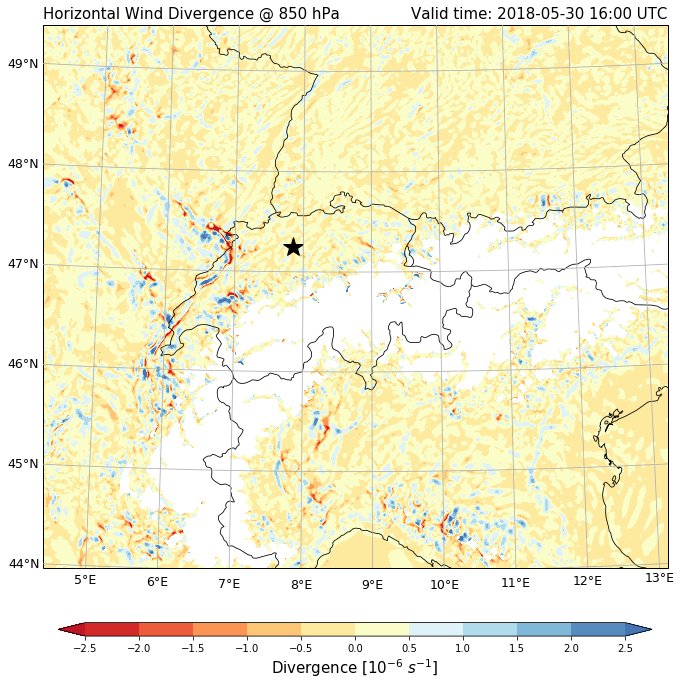

KeyboardInterrupt: 

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f74fe076e18> (for post_execute):


KeyboardInterrupt: 

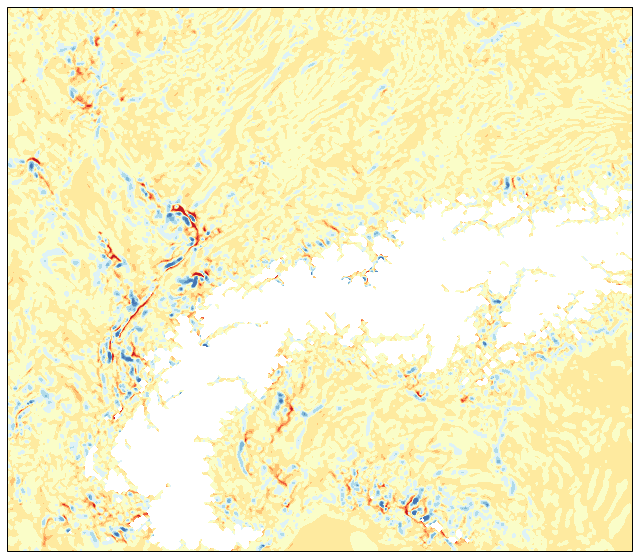

In [5]:
horizontal_map("divergence", "2018-05-30", 16, 19, pressure_level=850,
                subset=False, initiation=True, 
                save=False, gif=False)